In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vamshi2203a52127","key":"7f6f18972d6e93029e69a686f7597d8c"}'}

In [ ]:
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the uploaded kaggle.json to the right location
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d pathikviramgama/fake-news-dataset-1

import zipfile

with zipfile.ZipFile('fake-news-dataset-1.zip', 'r') as zip_ref:
    zip_ref.extractall()


Dataset URL: https://www.kaggle.com/datasets/pathikviramgama/fake-news-dataset-1
License(s): unknown


In [ ]:
import pandas as pd

# Load the 'true.csv' and 'fake.csv' files into DataFrames
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

# Add a label column
true_df['label'] = 'real'
fake_df['label'] = 'fake'

# Concatenate the two DataFrames
df = pd.concat([true_df, fake_df], ignore_index=True)

# Show the first few rows of the combined dataset
df.head()


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",real


In [ ]:
true_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer # Import from tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import from tensorflow.keras

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    text = text.strip().lower()          # Convert to lowercase and strip leading/trailing spaces
    return text

# Apply cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)


In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
# Tokenize the cleaned text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Remove stopwords
df['tokens_no_stopwords'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize tokens
df['tokens_lemmatized'] = df['tokens_no_stopwords'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into strings
df['processed_text'] = df['tokens_lemmatized'].apply(lambda tokens: ' '.join(tokens))

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the processed text
X_tfidf = tfidf.fit_transform(df['processed_text'])


In [ ]:
from sklearn.model_selection import train_test_split

# Encode labels
df['label_encoded'] = df['label'].map({'real': 0, 'fake': 1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label_encoded'], test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Initialize models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier()
nb_model = MultinomialNB()
svm_model = SVC()

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)


SVC()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Classification reports
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Accuracy scores
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64      4650
           1       0.61      0.53      0.56      4330

    accuracy                           0.61      8980
   macro avg       0.61      0.60      0.60      8980
weighted avg       0.61      0.61      0.60      8980

Random Forest:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      4650
           1       0.90      0.87      0.88      4330

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.89      8980
weighted avg       0.89      0.89      0.89      8980

Naive Bayes:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      4650
           1       0.57      0.57      0.57      4330

    accuracy                           0.58      8980
   macro avg       0.58      0.58      0.58      8980
weighted avg       0.5

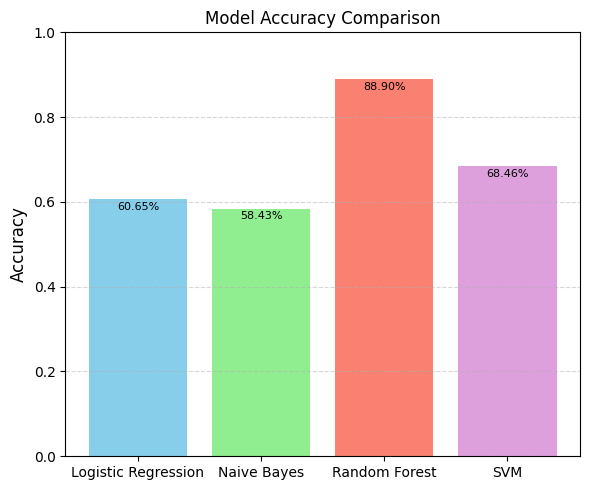

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their corresponding accuracies
model_names = ['Logistic Regression','Naive Bayes','Random Forest','SVM']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_svm)
]

# Create the bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'plum'])

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.03,
             f'{acc:.2%}', ha='center', va='bottom', fontsize=8)

# Set chart title and labels
plt.title('Model Accuracy Comparison', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['processed_text'])

# Pad sequences
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - accuracy: 0.8086 - loss: 0.3964 - val_accuracy: 0.9313 - val_loss: 0.1775
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - accuracy: 0.9565 - loss: 0.1159 - val_accuracy: 0.9698 - val_loss: 0.0935
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.9782 - loss: 0.0781 - val_accuracy: 0.9735 - val_loss: 0.0883
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - accuracy: 0.9822 - loss: 0.0686 - val_accuracy: 0.9794 - val_loss: 0.0703
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 79s 85ms/step - accuracy: 0.9913 - loss: 0.0391 - val_accuracy: 0.9794 - val_loss: 0.0672


In [ ]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4650
           1       0.98      0.98      0.98      4330

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 67s 119ms/step - accuracy: 0.9841 - loss: 0.0591 - val_accuracy: 0.9762 - val_loss: 0.0740
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 69s 96ms/step - accuracy: 0.9925 - loss: 0.0301 - val_accuracy: 0.9788 - val_loss: 0.0881
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 76s 85ms/step - accuracy: 0.9925 - loss: 0.0266 - val_accuracy: 0.9798 - val_loss: 0.0811
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.9966 - loss: 0.0167 - val_accuracy: 0.9833 - val_loss: 0.0666
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.9972 - loss: 0.0121 - val_accuracy: 0.9826 - val_loss: 0.0758


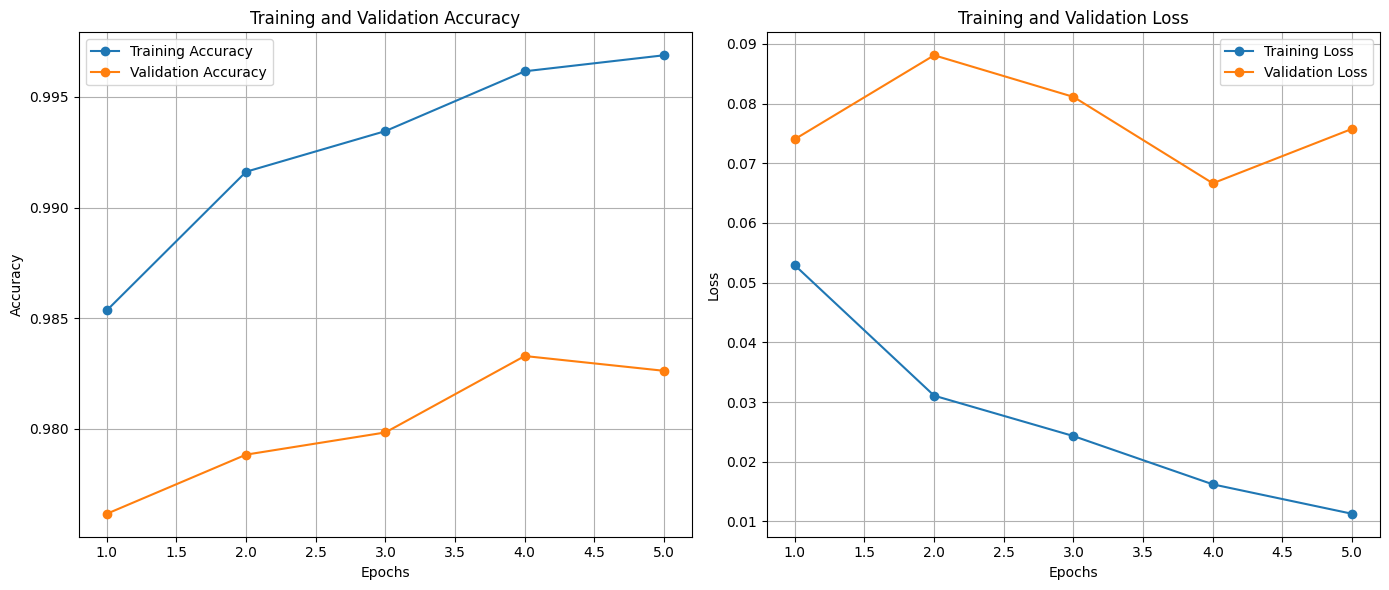

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


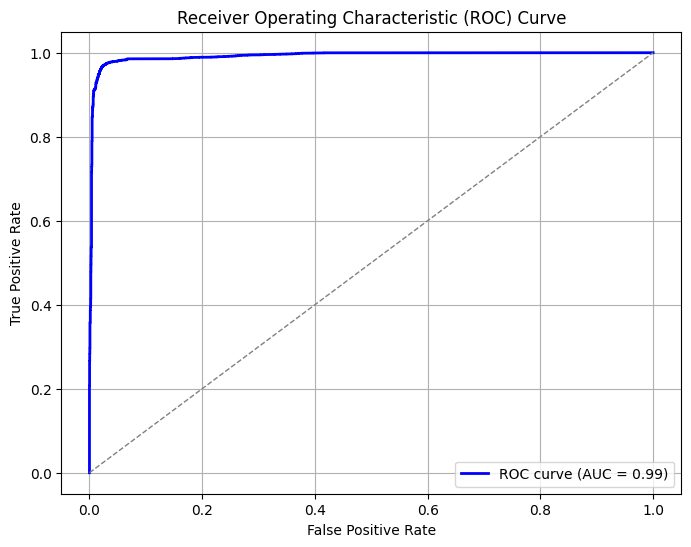

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = model.predict(X_test).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


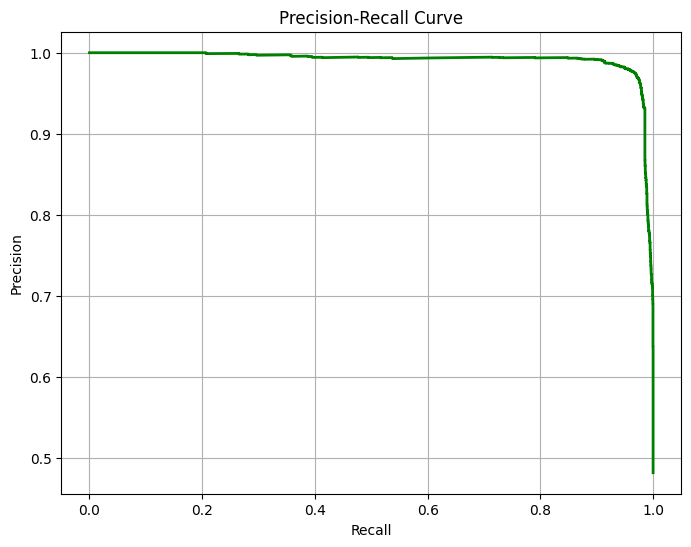

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Binarize predictions based on a threshold (e.g., 0.5)
y_pred = (y_probs >= 0.5).astype(int)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate error rates
type_i_error_rate = fp / (fp + tn)
type_ii_error_rate = fn / (fn + tp)

print(f"Type I Error Rate (False Positive Rate): {type_i_error_rate:.2%}")
print(f"Type II Error Rate (False Negative Rate): {type_ii_error_rate:.2%}")


Type I Error Rate (False Positive Rate): 1.57%
Type II Error Rate (False Negative Rate): 5.20%


In [ ]:
from statsmodels.stats.weightstats import ztest

# Example: Comparing model accuracy to a baseline (e.g., 0.5)
# Assuming 'accuracies' is a list of accuracy scores from cross-validation
z_stat, p_value = ztest(acc, value=0.5)
print(f"Z-Statistic: {z_stat:.2f}, P-Value: {p_value:.4f}")


Z-Statistic: 61.40, P-Value: 0.0000
